In [2]:
# All necessary imports for this notebook

# for data processing
import math
import pandas as pd
import geohash

# for visualization
import folium
from folium import plugins

%matplotlib inline
import matplotlib.pyplot as plt

In [92]:
# Load Air Tube Data into a Data Frame

df = pd.DataFrame(pd.read_csv('data_bg_2018.csv'))

In [93]:
# Extract longitude from geohash
def get_longitude(ghash):
    try:
        return geohash.decode(ghash)[0]
    except ValueError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1

# Extract lattitude from geohash
def get_lattitude(ghash):
    try:
        return geohash.decode(ghash)[1]
    except ValueError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1

# Assign longitude and lattitude
df['longitude'] = df['geohash'].apply(get_longitude)
df['latitude'] = df['geohash'].apply(get_lattitude)

value: nan, error: argument 1 must be str, not float
value: nan, error: argument 1 must be str, not float
value: nan, error: argument 1 must be str, not float
value: nan, error: argument 1 must be str, not float
geohash: nan, error: argument 1 must be str, not float
geohash: nan, error: argument 1 must be str, not float
geohash: nan, error: argument 1 must be str, not float
geohash: nan, error: argument 1 must be str, not float


In [94]:
# Remove rows with an invalid geohash

df = df[(df['longitude'] != -1) & (df['latitude'] != -1)]

In [95]:
# Filter data only for Sofia

def distance(x1, x2, y1, y2):
    return math.sqrt((y1 - x1) ** 2 + (y2 - x2) ** 2)

sofia_center = [42.697708, 23.321867]
german_village = [42.609620, 23.410710]
sofia_radius = distance(*sofia_center, *german_village)

df['in_sofia'] = df[['longitude', 'latitude']].apply(
    lambda point: 1 if distance(*point, *sofia_center) < sofia_radius else 0, axis=1
)

# unique_geohashes = df['geohash'].unique()

# Save to CSV
# df[df.in_sofia == 1][['geohash', 'longitude', 'latitude']].to_csv('geohash_mapping_sofia_2017.csv', index=False)

sofia_df = df[df.in_sofia == 1]

sofia_df.head()

,time,geohash,P1,P2,temperature,humidity,pressure,longitude,latitude,in_sofia
7,2018-01-01T00:00:00Z,sx8dfgvfgj8,371,208,4,66,95532,42.692000,23.332000,1
8,2018-01-01T00:00:00Z,sx8dfvjgen8,493,223,1,75,95527,42.699001,23.332000,1
9,2018-01-01T00:00:00Z,sx8df8vvdxj,420,235,1,73,95155,42.676001,23.320999,1
10,2018-01-01T00:00:00Z,sx8df4x60ss,433,253,3,66,95172,42.684999,23.300999,1
11,2018-01-01T00:00:00Z,sx8dgdsrvr5,405,178,0,76,95273,42.686000,23.363000,1


In [96]:
sofia_df.describe()

,P1,P2,temperature,humidity,pressure,longitude,latitude,in_sofia
count,1.528096e+06,1.528096e+06,1.528096e+06,1.528096e+06,1.528096e+06,1.528096e+06,1.528096e+06,1528096.0
mean,3.188629e+01,1.777127e+01,1.414625e+01,5.858794e+01,8.189348e+04,4.267574e+01,2.332158e+01,1.0
std,1.058198e+02,5.508366e+01,2.086160e+01,2.440127e+01,3.253682e+04,3.387663e-02,4.597483e-02,0.0
min,0.000000e+00,0.000000e+00,-5.573000e+03,-9.990000e+02,0.000000e+00,4.258000e+01,2.321800e+01,1.0
25%,8.000000e+00,5.000000e+00,6.000000e+00,4.400000e+01,9.356400e+04,4.265500e+01,2.328400e+01,1.0
50%,1.400000e+01,9.000000e+00,1.700000e+01,6.200000e+01,9.449800e+04,4.267500e+01,2.332200e+01,1.0
75%,2.400000e+01,1.500000e+01,2.200000e+01,7.600000e+01,9.505600e+04,4.269400e+01,2.336000e+01,1.0
max,2.000000e+03,1.000000e+03,6.400000e+01,1.100000e+02,1.649900e+05,4.280400e+01,2.342000e+01,1.0


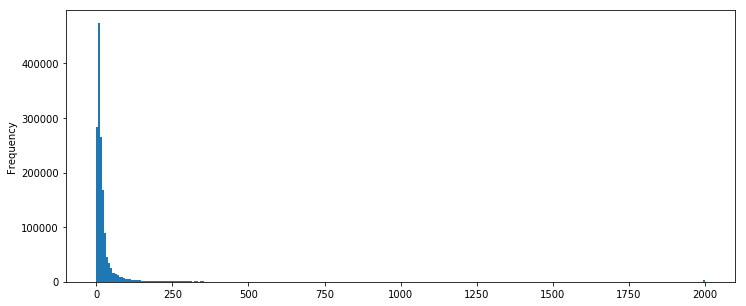

In [97]:
sofia_df.P1.plot.hist(bins=300, figsize=(12, 5))

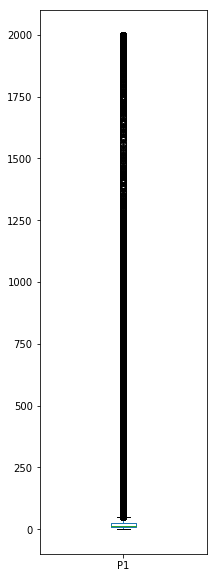

In [98]:
sofia_df.P1.plot.box(figsize=(3, 10))

In [99]:
def make_heatmap(df, timestamp, metric):
    points = df[df.time == timestamp]

    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11,
                            tiles='Stamen Terrain')

    for i in range(0, len(points)):
        point = points.iloc[i]
        
        folium.Circle(
            radius=10,
            location=[point['longitude'], point['latitude']],
            popup=str(point['P1']),
            color='#333333',
            fill=False
        ).add_to(folium_map)

    # plot heatmap
    folium_map.add_child(plugins.HeatMap(
        points[['longitude', 'latitude', metric]].as_matrix(),
        min_opacity=0.2,
        max_val=points[metric].max(),
        radius=30, blur=17,
        max_zoom=1
    ))

    # You can also save the interactive heat map as an HTML file
    # folium_map.save("output-map.html")
    return folium_map

In [101]:
# TODO: add Heat Map with Time Series
# TODO: documentation

make_heatmap(sofia_df, '2018-08-06T20:00:00Z', 'P1')

In [102]:
make_heatmap(sofia_df, '2018-08-06T20:00:00Z', 'humidity')

In [120]:
def make_time_series_heatmap(df, metric):
    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11.5,
                            tiles='Stamen Terrain')

    mean_weight = df[metric].mean()

    time_index = sorted(df.time.unique())
    print("time series with {} time points".format(len(time_index)))

    map_data = [None] * len(time_index)

    for index, timestamp in enumerate(time_index):
        points = df[df.time == timestamp][['longitude', 'latitude', 'P1']].values
        points[:, 2] /= mean_weight
        map_data[index] = points.tolist()
        
    heat_map = plugins.HeatMapWithTime(
        map_data,
        index=time_index,
        auto_play=True,
        radius=mean_weight,
        max_speed=24
#         max_opacity=0.3
    )

    heat_map.add_to(folium_map)

#     # plot heatmap
#     folium_map.add_child(plugins.HeatMap(
#         points[['longitude', 'latitude', metric]].as_matrix(),
#         min_opacity=0.2,
#         max_val=points[metric].max(),
#         radius=30, blur=17,
#         max_zoom=1
#     ))

    # You can also save the interactive heat map as an HTML file
    folium_map.save("heatmap-timeseries.html")
    return folium_map

In [ ]:
make_time_series_heatmap(sofia_df, 'P1')

time series with 5461 time points
